In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sps
from scipy.interpolate import CubicSpline

In [3]:
def br(E, lambdau, L, K, I, n, betax, betay, ex, ey):
    """
    calculates brightness for given parameters
    
    E: electron beam energy (GeV)
    labmdau: period (mm)
    L: length of undulator (meters)
    K: deflection parameter (unitless)
    I: beam current (amperes)
    n: harmonic number (unitless, odd number)
    betax: horizontal beta function (meters)
    betay: vertical beta function (meters)
    ex: horizontal emittance (m rad)
    ey: vertical emittance (m rad)
    
    returns: two element list [photon energy (keV), brightness (ph/s/mm^2/mrad^2/0.1%bw)]
    """
    # calculate the number of periods
    N = L / lambdau
    
    # photon energy
    eph = n*(.95*(E)**2)/(lambdau*100*(1+K**2/2))

    if L <= 0:
        return [eph, 0]
    
    # photon wavelength
    lmbda = 1.23980 / (eph*1000) * 1e4
    
    #calculate
    v = n*K**2/(4*(1+K**2/2))
    Qn = (n*K**2/(1+K**2/2))*((sps.jv((n-1)/2, v))-(sps.jv((n+1)/2, v)))**2
    Fn = (1.43e14*N*Qn*I)
    sigr = 1/(4*np.pi)*np.sqrt(lmbda*0.0000000001*L)
    sigrp = (np.sqrt(lmbda*0.0000000001/L))
    sigx = np.sqrt(betax*ex)
    sigy = np.sqrt(betay*ey)
    sigxp = np.sqrt(ex/betax)
    sigyp = np.sqrt(ey/betay)
    sigTx = np.sqrt(sigx**2 + sigr**2)
    sigTy = np.sqrt(sigy**2 + sigr**2)
    sigTxp = np.sqrt(sigxp**2 + sigrp**2)
    sigTyp = np.sqrt(sigyp**2 + sigrp**2)
    mybr = (Fn*0.000001*0.000001)/(((2*np.pi)**2)*sigTx*sigTy*sigTxp*sigTyp)

    return [eph, mybr]

def bptest(E, eph, lambdau, n):
    """
    returns peak magnetic field (Tesla)
    """
    C1 = 9.5
    C2 = 0.0934
    A = 2*(C1*E**2/(eph/n) - lambdau)
    if A < 0:
        return -1
    return np.sqrt(A/(C2**2*lambdau**3))

def getK(lambdau, Bp):
    """
    returns K from b field and period
    lambdau: mm
    Bp: Tesla
    """
    return (.0934*lambdau*Bp)

def gaptest(lambdau, eph, E, n, args=[0, 0, 0]):
    """
    returns gap from given parameters (mm)
    """
    C1 = 9.5
    C2 = 0.0934
    a, b, c = args
    v = (2 * (C1 * E ** 2 / (eph / n) - lambdau) / (C2 ** 2 * lambdau ** 3))
    
    if c == 0:
        if v <= 0:
            return np.nan
        v_sqrt = np.sqrt(v)
        log_v_a = np.log(v_sqrt) - np.log(a)
        u2 = lambdau * log_v_a / b
        return u2
    
    else:
        if v <= 0:
            return (np.nan, np.nan)
    
        v_sqrt = np.sqrt(v)
        log_v_a = np.log(v_sqrt / a)
        sqrt_term = b ** 2 + 4 * log_v_a * c

        if sqrt_term < 0:
            return (np.nan, np.nan)
    
        u1 = lambdau * ((-b + np.sqrt(sqrt_term)) / (2 * c))
        u2 = lambdau * ((-b - np.sqrt(sqrt_term)) / (2 * c))
    
        positive_gaps = [gap for gap in [u1, u2] if gap > 0]
        return u2

def lengthtest(betay, ey, gap2, Nsig):
    """
    returns length of device based on given parameters (meters)
    """
    A = (1/ey)*(gap2/Nsig/100)**2-betay
    if A < 0:
        return 0
    return 2*np.sqrt(betay)*np.sqrt(A)

In [4]:
lambdaus = np.linspace(16, 25, 19)
ephs = np.linspace(1, 90, 200)
ns = np.arange(1, 31.1, 2)

def bestgraphppmplanar(E, I, betax, betay, ex, ey, Nsig):
    max_brightness_per_eph = []

    for thiseph in ephs:
        mybest = [thiseph, 0, 0, 0, 0, 0, 0, 0]

        for lambdau in lambdaus:
            for n in ns:
                # Calculate the parameters
                thatBp = bptest(E, thiseph, lambdau, n)
            
                if thatBp < 0:
                    continue
            
                thatgap2 = gaptest(lambdau, thiseph, E, n, [2.076, -3.24, 0])
                
                if np.any(np.isnan(thatgap2)):
                    continue
                
                if thatgap2 <= 0:
                    continue
                    
                thatL = lengthtest(betay, ey, thatgap2, Nsig)/1000            
                thatK = getK(lambdau, thatBp)
                results = br(E, lambdau*1e-3, thatL, thatK, I, n, betax, betay, ex, ey)
            
                # Check and update the best brightness
                if results[1] > mybest[1]:
                    mybest = [thiseph, results[1], lambdau, thatL, thatBp, n, thatK, thatgap2]
            
            # Store the best result for this eph
        if mybest[1] > 0:
            max_brightness_per_eph.append(mybest)

    return(max_brightness_per_eph)

def bestgraphppmhelical(E, I, betax, betay, ex, ey, Nsig):
    
    n = 1
    
    max_brightness_per_eph = []

    for thiseph in ephs:
        mybest = [thiseph, 0, 0, 0, 0, 0, 0, 0]

        for lambdau in lambdaus:
            # Calculate the parameters
            thatBp = bptest(E, thiseph, lambdau, n)
            
            if thatBp < 0:
                continue
            
            thatgap2 = gaptest(lambdau, thiseph, E, n, [1.614, -4.67, .62])
                
            if np.any(np.isnan(thatgap2)):
                continue
                
            if thatgap2 <= 0:
                continue
                    
            thatL = lengthtest(betay, ey, thatgap2, Nsig)/1000            
            thatK = getK(lambdau, thatBp)
            results = br(E, lambdau*1e-3, thatL, thatK, I, n, betax, betay, ex, ey)
            
            # Check and update the best brightness
            if results[1] > mybest[1]:
                mybest = [thiseph, results[1], lambdau, thatL, thatBp, n, thatK, thatgap2]
            
        # Store the best result for this eph
        if mybest[1] > 0:
            max_brightness_per_eph.append(mybest)

    return(max_brightness_per_eph)

def bestgraphhybrid(E, I, betax, betay, ex, ey, Nsig):
    max_brightness_per_eph = []

    for thiseph in ephs:
        mybest = [thiseph, 0, 0, 0, 0, 0, 0, 0]

        for lambdau in lambdaus:
            for n in ns:
                # Calculate the parameters
                thatBp = bptest(E, thiseph, lambdau, n)
            
                if thatBp < 0:
                    continue
            
                thatgap2 = gaptest(lambdau, thiseph, E, n, [3.381, -4.73, 1.198])
                
                if np.any(np.isnan(thatgap2)):
                    continue
                
                if thatgap2 <= 0:
                    continue
                    
                thatL = lengthtest(betay, ey, thatgap2, Nsig)/1000            
                thatK = getK(lambdau, thatBp)
                results = br(E, lambdau*1e-3, thatL, thatK, I, n, betax, betay, ex, ey)
            
                # Check and update the best brightness
                if results[1] > mybest[1]:
                    mybest = [thiseph, results[1], lambdau, thatL, thatBp, n, thatK, thatgap2]
            
            # Store the best result for this eph
        if mybest[1] > 0:
            max_brightness_per_eph.append(mybest)
            
    return(max_brightness_per_eph)

def bestgraphsuperconducting(E, I, betax, betay, ex, ey, Nsig):
    max_brightness_per_eph = []

    for thiseph in ephs:
        mybest = [thiseph, 0, 0, 0, 0, 0, 0, 0]

        for lambdau in lambdaus:
            for n in ns:
                # Calculate the parameters
                thatBp = bptest(E, thiseph, lambdau, n)
            
                if thatBp < 0:
                    continue
            
                thatgap2 = gaptest(lambdau, thiseph, E, n, [11.73, -5.52, .856])
                
                if np.any(np.isnan(thatgap2)):
                    continue
                
                if thatgap2 <= 0:
                    continue
                    
                thatL = lengthtest(betay, ey, thatgap2, Nsig)/1000            
                thatK = getK(lambdau, thatBp)
                results = br(E, lambdau*1e-3, thatL, thatK, I, n, betax, betay, ex, ey)
            
                # Check and update the best brightness
                if results[1] > mybest[1]:
                    mybest = [thiseph, results[1], lambdau, thatL, thatBp, n, thatK, thatgap2]
            
            # Store the best result for this eph
        if mybest[1] > 0:
            max_brightness_per_eph.append(mybest)

    return(max_brightness_per_eph)

In [5]:
mythingppmplanar = bestgraphppmplanar(3, .5, 2, 2, 8e-10, 8e-12, 25)
mythingppmplanar2 = bestgraphppmplanar(4, .4, 2, 2, 25e-12, 8e-12, 25)

mythingppmhelical = bestgraphppmhelical(3, .5, 2, 2, 8e-10, 8e-12, 25)
mythingppmhelical2 = bestgraphppmhelical(4, .4, 2, 2, 25e-12, 8e-12, 25)

mythinghybrid = bestgraphhybrid(3, .5, 2, 2, 8e-10, 8e-12, 25)
mythinghybrid2 = bestgraphhybrid(4, .4, 2, 2, 25e-12, 8e-12, 25)

mythingsuperconducting = bestgraphsuperconducting(3, .5, 2, 2, 8e-10, 8e-12, 25)
mythingsuperconducting2 = bestgraphsuperconducting(4, .4, 2, 2, 25e-12, 8e-12, 25)

In [6]:
print(mythingppmplanar[100])
print(mythingppmplanar2[100])

print(mythingppmhelical[5])
print(mythingppmhelical2[5])

print(mythinghybrid[100])
print(mythinghybrid2[100])

print(mythingsuperconducting[100])
print(mythingsuperconducting2[100])

[45.72361809045226, 1.2085373462729339e+19, 16.0, 0.6915529009283132, 1.462779587616301, 29.0, 2.1859778157338003, 1.7289111724983974]
[45.72361809045226, 2.245472591515685e+21, 16.0, 1.3037599801182365, 1.0729494686063346, 11.0, 1.6034156858853064, 3.259415290506397]
[3.236180904522613, 1.6919137849351484e+21, 21.5, 3.0265483441340546, 0.3368948357756626, 1, 0.676518519721108, 7.566377468520102]
[3.236180904522613, 1.569768947446217e+22, 25.0, 2.3079222326317703, 0.5677572654478495, 1, 1.3257132148207287, 5.769814247376175]
[45.72361809045226, 2.9699049786179215e+19, 16.0, 1.1201470660164234, 1.5326624832441296, 31.0, 2.290410814960027, 2.800385519782501]
[45.72361809045226, 4.120162404166832e+21, 16.0, 1.280518796800404, 1.3767736180712182, 15.0, 2.0574504948456283, 3.2013126106325056]
[45.72361809045226, 9.279158300523512e+19, 16.0, 2.512545208533426, 1.5326624832441296, 31.0, 2.290410814960027, 6.281370981384297]
[45.72361809045226, 1.905504898154361e+22, 16.0, 2.0371684022712695, 

In [11]:
ephcolumn1 = [row[0] for row in mythingppmplanar]
brcolumn1 = [row[1] for row in mythingppmplanar]
lambdaucolumn1 = [row[2] for row in mythingppmplanar]
lengthcolumn1 = [row[3] for row in mythingppmplanar]
bpcolumn1 = [row[4] for row in mythingppmplanar]
hncolumn1 = [row[5] for row in mythingppmplanar]
kcolumn1 = [row[6] for row in mythingppmplanar]
gapcolumn1 = [row[7] for row in mythingppmplanar]

ephcolumn2 = [row[0] for row in mythingppmplanar2]
brcolumn2 = [row[1] for row in mythingppmplanar2]
lambdaucolumn2 = [row[2] for row in mythingppmplanar2]
lengthcolumn2 = [row[3] for row in mythingppmplanar2]
bpcolumn2 = [row[4] for row in mythingppmplanar2]
hncolumn2 = [row[5] for row in mythingppmplanar2]
kcolumn2 = [row[6] for row in mythingppmplanar2]
gapcolumn2 = [row[7] for row in mythingppmplanar2]


ephcolumn3 = [row[0] for row in mythingppmhelical]
brcolumn3 = [row[1] for row in mythingppmhelical]
lambdaucolumn3 = [row[2] for row in mythingppmhelical]
lengthcolumn3 = [row[3] for row in mythingppmhelical]
bpcolumn3 = [row[4] for row in mythingppmhelical]
hncolumn3 = [row[5] for row in mythingppmhelical]
kcolumn3 = [row[6] for row in mythingppmhelical]
gapcolumn3 = [row[7] for row in mythingppmhelical]

ephcolumn4 = [row[0] for row in mythingppmhelical2]
brcolumn4 = [row[1] for row in mythingppmhelical2]
lambdaucolumn4 = [row[2] for row in mythingppmhelical2]
lengthcolumn4 = [row[3] for row in mythingppmhelical2]
bpcolumn4 = [row[4] for row in mythingppmhelical2]
hncolumn4 = [row[5] for row in mythingppmhelical2]
kcolumn4 = [row[6] for row in mythingppmhelical2]
gapcolumn4 = [row[7] for row in mythingppmhelical2]


ephcolumn5 = [row[0] for row in mythinghybrid]
brcolumn5 = [row[1] for row in mythinghybrid]
lambdaucolumn5 = [row[2] for row in mythinghybrid]
lengthcolumn5 = [row[3] for row in mythinghybrid]
bpcolumn5 = [row[4] for row in mythinghybrid]
hncolumn5 = [row[5] for row in mythinghybrid]
kcolumn5 = [row[6] for row in mythinghybrid]
gapcolumn5 = [row[7] for row in mythinghybrid]

ephcolumn6 = [row[0] for row in mythinghybrid2]
brcolumn6 = [row[1] for row in mythinghybrid2]
lambdaucolumn6 = [row[2] for row in mythinghybrid2]
lengthcolumn6 = [row[3] for row in mythinghybrid2]
bpcolumn6 = [row[4] for row in mythinghybrid2]
hncolumn6 = [row[5] for row in mythinghybrid2]
kcolumn6 = [row[6] for row in mythinghybrid2]
gapcolumn6 = [row[7] for row in mythinghybrid2]


ephcolumn7 = [row[0] for row in mythingsuperconducting]
brcolumn7 = [row[1] for row in mythingsuperconducting]
lambdaucolumn7 = [row[2] for row in mythingsuperconducting]
lengthcolumn7 = [row[3] for row in mythingsuperconducting]
bpcolumn7 = [row[4] for row in mythingsuperconducting]
hncolumn7 = [row[5] for row in mythingsuperconducting]
kcolumn7 = [row[6] for row in mythingsuperconducting]
gapcolumn7 = [row[7] for row in mythingsuperconducting]

ephcolumn8 = [row[0] for row in mythingsuperconducting2]
brcolumn8 = [row[1] for row in mythingsuperconducting2]
lambdaucolumn8 = [row[2] for row in mythingsuperconducting2]
lengthcolumn8 = [row[3] for row in mythingsuperconducting2]
bpcolumn8 = [row[4] for row in mythingsuperconducting2]
hncolumn8 = [row[5] for row in mythingsuperconducting2]
kcolumn8 = [row[6] for row in mythingsuperconducting2]
gapcolumn8 = [row[7] for row in mythingsuperconducting2]

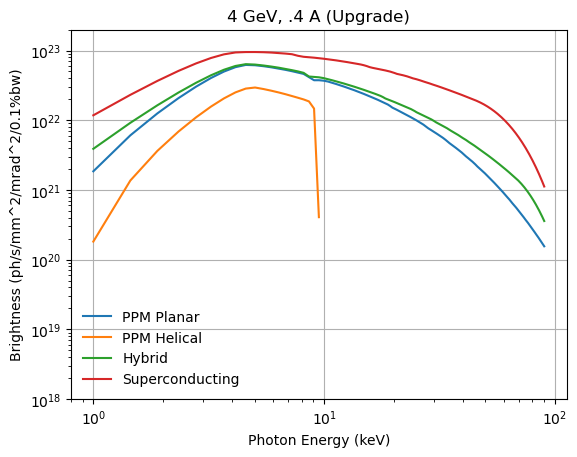

In [12]:
plt.figure()
plt.title('4 GeV, .4 A (Upgrade)')
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Brightness (ph/s/mm^2/mrad^2/0.1%bw)')
plt.loglog()
plt.plot([x for x in ephcolumn2], [x for x in brcolumn2], label='PPM Planar')
plt.plot([x for x in ephcolumn4], [x for x in brcolumn4], label='PPM Helical')
plt.plot([x for x in ephcolumn6], [x for x in brcolumn6], label='Hybrid')
plt.plot([x for x in ephcolumn8], [x for x in brcolumn8], label='Superconducting')
plt.legend(frameon=False)
plt.grid()
plt.ylim(1e18,2e23)
plt.savefig('myfigephbrresults.png')
plt.show()

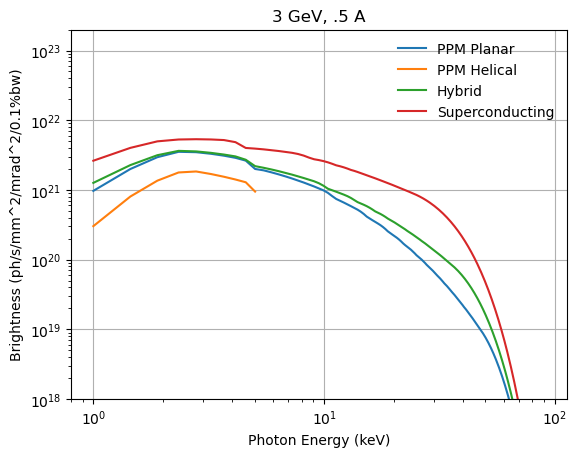

In [10]:
plt.figure()
plt.title('3 GeV, .5 A')
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Brightness (ph/s/mm^2/mrad^2/0.1%bw)')
plt.loglog()
plt.plot([x for x in ephcolumn1], [x for x in brcolumn1], label='PPM Planar')
plt.plot([x for x in ephcolumn3], [x for x in brcolumn3], label='PPM Helical')
plt.plot([x for x in ephcolumn5], [x for x in brcolumn5], label='Hybrid')
plt.plot([x for x in ephcolumn7], [x for x in brcolumn7], label='Superconducting')
plt.legend(frameon=False)
plt.grid()
plt.ylim(1e18,2e23)
plt.savefig('myfigephbrresults1.png')
plt.show()

In [25]:
cs = CubicSpline([x[0] for x in mything], [x[1] for x in mything], extrapolate = False)
cs1 = CubicSpline([x[0] for x in mything], [x[2] for x in mything], extrapolate = False)
cs2 = CubicSpline([x[0] for x in mything], [x[3] for x in mything], extrapolate = False)
cs3 = CubicSpline([x[0] for x in mything], [x[4] for x in mything], extrapolate = False)
cs4 = CubicSpline([x[0] for x in mything], [x[5] for x in mything], extrapolate = False)
cs5 = CubicSpline([x[0] for x in mything], [x[6] for x in mything], extrapolate = False)

def mycs(eph):
    return(float(cs(eph)), float(cs1(eph)), float(cs2(eph)), float(cs3(eph)), round(float(cs4(eph))), float(cs5(eph)))

mycs(1.55)

(2.6233293919917614e+21,
 24.973725073919397,
 3.929778855070409,
 0.6658838668629219,
 1,
 1.5540061489245915)